In [10]:
# import sys
# !{sys.executable} -m pip install plotly graphviz catboost nbformat seaborn==0.10.0 sklearn pandas numpy matplotlib

In [2]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import graphviz
from subprocess import call
from IPython.display import Image
from catboost import CatBoostClassifier, Pool

# Fraud detection in car insurance

Der folgende Datensatz enthält 1'000 Daten zu Schadenfällen in der Autoversicherung.

Von der Schadenabteilung wurden davon 247 Schäden als Versicherungsbetrug entlarvt (Spalte: fraud_reported = "Y").

Bitte entwickeln Sie ein einfaches, binäres Klassifikationsmodell zur Unterscheidung der Betrugsfälle von Nicht-Betrugsfällen.

Halten Sie die Analyse für diesen Proof-of-concept einfach. Ergebnisse (z.B. als Tabelle, Grafiken, Reporting) sowie den verwendeten Code.

## Data

In [3]:
raw_data = pd.read_csv('data/car_insurance_fraud.csv')

### Statistische Beschreibung

In [4]:
raw_data.describe()

months_as_customer          age  policy_number  policy_deductable  \
count         1000.000000  1000.000000    1000.000000        1000.000000   
mean           203.954000    38.948000  546238.648000        1136.000000   
std            115.113174     9.140287  257063.005276         611.864673   
min              0.000000    19.000000  100804.000000         500.000000   
25%            115.750000    32.000000  335980.250000         500.000000   
50%            199.500000    38.000000  533135.000000        1000.000000   
75%            276.250000    44.000000  759099.750000        2000.000000   
max            479.000000    64.000000  999435.000000        2000.000000   

       policy_annual_premium  umbrella_limit    insured_zip  capital-gains  \
count            1000.000000    1.000000e+03    1000.000000    1000.000000   
mean             1256.406150    1.101000e+06  501214.488000   25126.100000   
std               244.167395    2.297407e+06   71701.610941   27872.187708   
min               433.330000   -1.000000e+06  430104.000000       0.000000   
25%              1089.607500    0.000000e+00  448404.500000       0.000000   
50%              1257.200000    0.000000e+00  466445.500000       0.000000   
75%              1415.695000    0.000000e+00  603251.000000   51025.000000   
max              2047.590000    1.000000e+07  620962.000000  100500.000000   

        capital-loss  incident_hour_of_the_day  number_of_vehicles_involved  \
count    1000.000000               1000.000000                   1000.00000   
mean   -26793.700000                 11.644000                      1.83900   
std     28104.096686                  6.951373                      1.01888   
min   -111100.000000                  0.000000                      1.00000   
25%    -51500.000000                  6.000000                      1.00000   
50%    -23250.000000                 12.000000                      1.00000   
75%         0.000000                 17.000000                      3.00000   
max         0.000000                 23.000000                      4.00000   

       bodily_injuries    witnesses  total_claim_amount  injury_claim  \
count      1000.000000  1000.000000          1000.00000   1000.000000   
mean          0.992000     1.487000         52761.94000   7433.420000   
std           0.820127     1.111335         26401.53319   4880.951853   
min           0.000000     0.000000           100.00000      0.000000   
25%           0.000000     1.000000         41812.50000   4295.000000   
50%           1.000000     1.000000         58055.00000   6775.000000   
75%           2.000000     2.000000         70592.50000  11305.000000   
max           2.000000     3.000000        114920.00000  21450.000000   

       property_claim  vehicle_claim    auto_year  
count     1000.000000    1000.000000  1000.000000  
mean      7399.570000   37928.950000  2005.103000  
std       4824.726179   18886.252893     6.015861  
min          0.000000      70.000000  1995.000000  
25%       4445.000000   30292.500000  2000.000000  
50%       6750.000000   42100.000000  2005.000000  
75%      10885.000000   50822.500000  2010.000000  
max      23670.000000   79560.000000  2015.000000

### Verteilung Betrugsfälle zur Gesamtmenge

In [5]:
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Bar(x=['no fraud','fraud'], y=raw_data['fraud_reported'].value_counts(normalize=True)), row=1, col=2)
fig.update_layout(yaxis=dict(tickformat="%"), height=400)

fig.show()

Die Daten weisen eine schiefe Verteilung auf. Nur ca. 25% der Fälle wurden als Betrug markiert. 

### Räumliche Betrachtung

Anteil von identifizierten Betrugsfällen an allen Versicherungsfällen nach Bundesstaat. 

In [5]:
per_state = pd.DataFrame(raw_data.groupby(['incident_state', 'fraud_reported']).size(), columns=['count'])
per_state_fraction = per_state.groupby('incident_state')['count'].transform(lambda x: x/sum(x))

fig = go.Figure(data=go.Choropleth(
    locations=per_state_fraction.xs('Y',level='fraud_reported').index, 
    locationmode="USA-states",
    colorscale = 'Reds',
    z=per_state_fraction.xs('Y',level='fraud_reported'),
    colorbar_title = "fraud(%)")
    )
fig.update_layout(
    geo_scope='usa', # limite map scope to USA
)
fig.show()

## Daten vorbereiten (preprocessing)

Bevor aus den Daten ein Modell berechtet werden kann, müssen sie vorbereitet werden:
- ggf. irrelevante Informationen identifizieren und aussortieren
- Fehlwerte behandeln
- kategorisch (textuale) Werte in numerische Repräsentationen übersetzen

In [6]:
print(str(len(raw_data.columns)-1) + ' Prediktoren: ')
print('Nullwerte: ' + str(raw_data.isnull().values.sum()))
raw_data.iloc[:,:(len(raw_data.columns)-1)].dtypes

38 Prediktoren: 
Nullwerte: 0


months_as_customer               int64
age                              int64
policy_number                    int64
policy_bind_date                object
policy_state                    object
policy_csl                      object
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_zip                      int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_date                   object
incident_type                   object
collision_type                  object
incident_severity               object
authorities_contacted           object
incident_state                  object
incident_city                   object
incident_location               object
incident_hour_of_the_day 

In [7]:
for col in raw_data.columns:
    if raw_data[col].nunique() > 500:
        print(col + ': ' + str(raw_data[col].nunique()))

policy_number: 1000
policy_bind_date: 951
policy_annual_premium: 991
insured_zip: 995
incident_location: 1000
total_claim_amount: 763
injury_claim: 638
property_claim: 626
vehicle_claim: 726


In [8]:
sns.diverging_palette(5, 5, as_cmap=True)

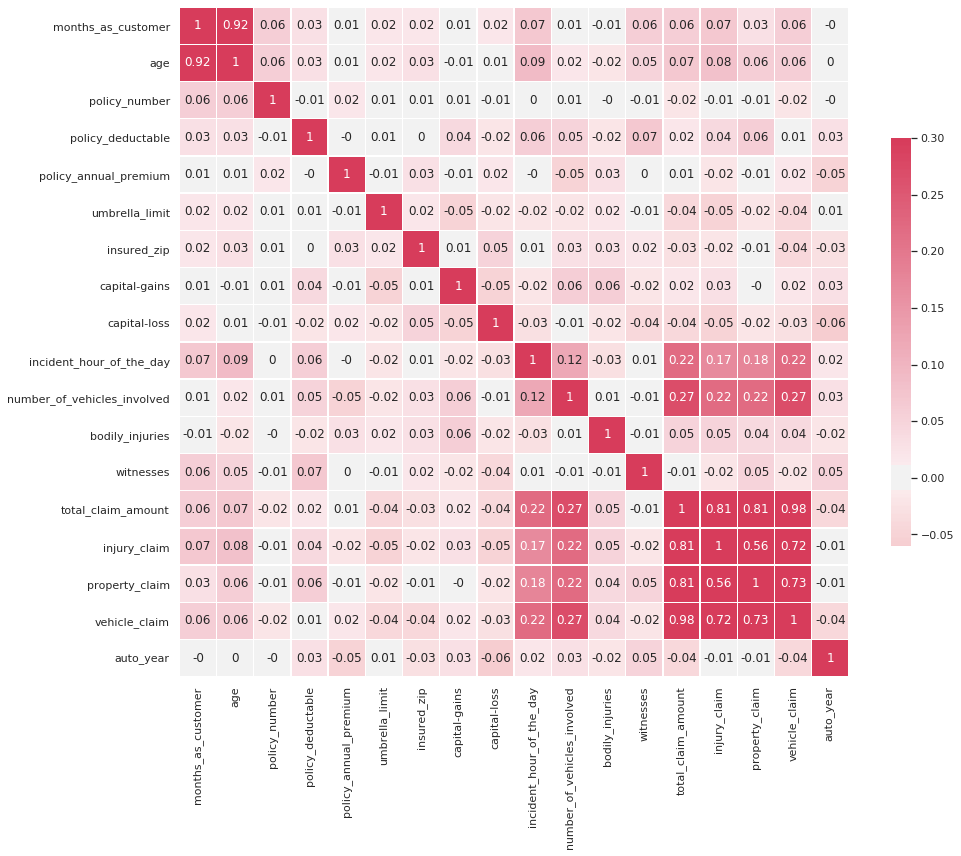

In [9]:
sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 5, as_cmap=True)

sns.heatmap(raw_data.corr().round(2), cmap=cmap, vmax=.3, center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Prediktoren entfernen, welche keine Bedeutung haben:
- Werte, für welche mehr als 500 Einzelwerte verfügbar sind
    - policy_number
    - incident_location
    - insured_zip
- und Werte, welche durch andere Werte repräsentiert werden (policy_bind_date, da durch months_as_customer)

Aus Datumsinformationen werden potentiell interessante Informationen extrahiert:
- Jahr
- Monat
- Wochentag

In [10]:
data = raw_data.copy()

data.loc[:,'policy_bind_date_month'] = pd.DatetimeIndex(data.loc[:,'policy_bind_date']).month
data.loc[:,'policy_bind_date_year'] = pd.DatetimeIndex(data.loc[:,'policy_bind_date']).year
data.loc[:,'policy_bind_date_dayofweek'] = pd.DatetimeIndex(data.loc[:,'policy_bind_date']).dayofweek
data.loc[:,'incident_month'] = pd.DatetimeIndex(data.loc[:,'incident_date']).month
data.loc[:,'incident_dayofweek'] = pd.DatetimeIndex(data.loc[:,'incident_date']).dayofweek
# incident_year nicht notwendig, da alles 2015

columns_drop = ['policy_number', 
                'policy_bind_date', 
                'incident_date' , 
                'policy_annual_premium', 
                'insured_zip', 
                'incident_location'] 
data.drop(columns=columns_drop, inplace=True)

data['fraud_reported'] = data['fraud_reported'].replace(('Y','N'),(1,0))

# Duplicate ausschliessen
data.drop_duplicates(inplace=True)

data.head(3)

months_as_customer  age policy_state policy_csl  policy_deductable  \
0                 328   48           OH    250/500               1000   
1                 228   42           IN    250/500               2000   
2                 134   29           OH    100/300               2000   

   umbrella_limit insured_sex insured_education_level insured_occupation  \
0               0        MALE                      MD       craft-repair   
1         5000000        MALE                      MD  machine-op-inspct   
2         5000000      FEMALE                     PhD              sales   

  insured_hobbies  ... vehicle_claim  auto_make  auto_model auto_year  \
0        sleeping  ...         52080       Saab         92x      2004   
1         reading  ...          3510   Mercedes        E400      2007   
2     board-games  ...         23100      Dodge         RAM      2007   

  fraud_reported policy_bind_date_month policy_bind_date_year  \
0              1                     10                  2014   
1              1                      6                  2006   
2              0                      6                  2000   

  policy_bind_date_dayofweek incident_month  incident_dayofweek  
0                          4              1                   6  
1                          1              1                   2  
2                          4              2                   6  

[3 rows x 38 columns]

### Kategorische nicht-numerische Werte ersetzen

In [11]:
for col in data.columns:
    if data[col].nunique() < 500 and data[col].dtype=='object' :
        print(col + ': ' + str(data[col].nunique()))

policy_state: 3
policy_csl: 3
insured_sex: 2
insured_education_level: 7
insured_occupation: 14
insured_hobbies: 20
insured_relationship: 6
incident_type: 4
collision_type: 4
incident_severity: 4
authorities_contacted: 5
incident_state: 7
incident_city: 7
property_damage: 3
police_report_available: 3
auto_make: 14
auto_model: 39


Für folgende Werte existieren sehr viele Werte:
    - auto_model
    - auto_make
    - insured_occupation
    - insured_hobbies

In [12]:
classes = ['auto_model', 'auto_make', 'insured_occupation', 'insured_hobbies','fraud_reported']
check_classes = data.loc[:,classes]
check_classes


auto_model   auto_make insured_occupation insured_hobbies  fraud_reported
0          92x        Saab       craft-repair        sleeping               1
1         E400    Mercedes  machine-op-inspct         reading               1
2          RAM       Dodge              sales     board-games               0
3        Tahoe   Chevrolet       armed-forces     board-games               1
4          RSX      Accura              sales     board-games               0
..         ...         ...                ...             ...             ...
995     Accord       Honda       craft-repair       paintball               0
996     Passat  Volkswagen     prof-specialty        sleeping               0
997    Impreza      Suburu       armed-forces  bungie-jumping               0
998         A5        Audi  handlers-cleaners    base-jumping               0
999       E400    Mercedes              sales        kayaking               0

[1000 rows x 5 columns]

In [13]:
classes = ['auto_model', 'auto_make', 'insured_occupation', 'insured_hobbies','fraud_reported']
check_classes = data.loc[:,classes]
fig = make_subplots(rows=4, cols=1)
for i, c in enumerate(classes[:4]):
    sl=True if i==0 else False
    fig.add_trace(go.Bar(showlegend=sl, marker=dict(color="MediumPurple"), name='no fraud', x=check_classes.loc[check_classes.fraud_reported==0,c].unique(), y=check_classes.loc[check_classes.fraud_reported==0,'auto_model'].value_counts(normalize=True)), row=i+1, col=1)
    fig.add_trace(go.Bar(showlegend=sl, marker=dict(color="LightSeaGreen"), name='fraud', x=check_classes.loc[check_classes.fraud_reported==1,c].unique(), y=check_classes.loc[check_classes.fraud_reported==1,'auto_model'].value_counts(normalize=True)), row=i+1, col=1)
    

fig.update_layout(height=1000)
fig.show()

Für alle vier Werte gibt es Unterschiede in der Häufigkeit von Betrug abhängig von Wert. Bei auto_model und insured_hobby treten diese stärker auf. Bei auto_make und insure_occupation treten sie weniger stark in Erscheinung. Trotzdem wird vereinfacht für alle Parameter das gleiche Verfahren verwendet: Hierzu werden wird die relative Häufigkeit von Betrugsfällen der jeweiligen Klasse substitutiert. Als Beispiel dient das auto_model:

In [14]:
data[data.fraud_reported==1]['auto_model'].value_counts(normalize=True)

RAM               0.056680
A5                0.044534
F150              0.040486
A3                0.040486
Jetta             0.040486
Tahoe             0.036437
Passat            0.036437
Silverado         0.036437
92x               0.032389
MDX               0.032389
ML350             0.032389
Forrestor         0.032389
Civic             0.032389
C300              0.028340
Maxima            0.028340
X6                0.028340
X5                0.028340
E400              0.028340
Highlander        0.024291
Impreza           0.024291
Neon              0.024291
Fusion            0.024291
Escape            0.024291
Grand Cherokee    0.024291
93                0.020243
Legacy            0.020243
95                0.020243
M5                0.020243
Wrangler          0.020243
TL                0.016194
Pathfinder        0.016194
Camry             0.016194
Ultima            0.012146
Malibu            0.012146
Accord            0.012146
Corolla           0.012146
CRV               0.012146
3

In [15]:
data_numerical = data.copy()
for c in classes[:4]:
    to_replace = dict(data[data.fraud_reported==1][c].value_counts(normalize=True))
    data_numerical[c].replace(to_replace, inplace=True)
data_numerical.head()

months_as_customer  age policy_state policy_csl  policy_deductable  \
0                 328   48           OH    250/500               1000   
1                 228   42           IN    250/500               2000   
2                 134   29           OH    100/300               2000   
3                 256   41           IL    250/500               2000   
4                 228   44           IL   500/1000               1000   

   umbrella_limit insured_sex insured_education_level  insured_occupation  \
0               0        MALE                      MD            0.089069   
1         5000000        MALE                      MD            0.089069   
2         5000000      FEMALE                     PhD            0.085020   
3         6000000      FEMALE                     PhD            0.068826   
4         6000000        MALE               Associate            0.085020   

   insured_hobbies  ... vehicle_claim  auto_make  auto_model auto_year  \
0         0.032389  ...         52080   0.072874    0.032389      2004   
1         0.068826  ...          3510   0.089069    0.028340      2007   
2         0.056680  ...         23100   0.080972    0.056680      2007   
3         0.056680  ...         50720   0.085020    0.036437      2014   
4         0.056680  ...          4550   0.052632    0.004049      2009   

  fraud_reported policy_bind_date_month policy_bind_date_year  \
0              1                     10                  2014   
1              1                      6                  2006   
2              0                      6                  2000   
3              1                      5                  1990   
4              0                      6                  2014   

  policy_bind_date_dayofweek incident_month  incident_dayofweek  
0                          4              1                   6  
1                          1              1                   2  
2                          4              2                   6  
3                          4             10                   3  
4                          4              2                   1  

[5 rows x 38 columns]

Alle restlichen Werte mit wenigen Klassen wird One-Hot encoding verwendet werden:

In [16]:
data_preprocessed = data_numerical.copy()
data_preprocessed= pd.get_dummies(data_preprocessed.iloc[:,:(len(raw_data.columns)-1)])
data_preprocessed.columns

Index(['months_as_customer', 'age', 'policy_deductable', 'umbrella_limit',
       'insured_occupation', 'insured_hobbies', 'capital-gains',
       'capital-loss', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'bodily_injuries', 'witnesses',
       'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
       'auto_make', 'auto_model', 'auto_year', 'fraud_reported',
       'policy_bind_date_month', 'policy_bind_date_year',
       'policy_bind_date_dayofweek', 'incident_month', 'incident_dayofweek',
       'policy_state_IL', 'policy_state_IN', 'policy_state_OH',
       'policy_csl_100/300', 'policy_csl_250/500', 'policy_csl_500/1000',
       'insured_sex_FEMALE', 'insured_sex_MALE',
       'insured_education_level_Associate', 'insured_education_level_College',
       'insured_education_level_High School', 'insured_education_level_JD',
       'insured_education_level_MD', 'insured_education_level_Masters',
       'insured_education_level_PhD', 'insure

# Model

Es werden verschiedene Modelle evaluiert:

### Trainingsdatensätze erzeugen und normieren

In [17]:
X = data_preprocessed.drop('fraud_reported',axis=1)
y = data_preprocessed['fraud_reported']
X_train0, X_test0, y_train, y_test = train_test_split(X, y, test_size=0.3)
feature_names = X_train0.columns

In [18]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train0)
X_test = sc.transform(X_test0)

### Evaluation von Gaussian Naive Bayes model

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

gnb = GaussianNB()

gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print('Accuracy:',metrics.accuracy_score(y_test, y_pred).round(3))

Accuracy: 0.647


### Evaluation von Random Forest Classifier

In [20]:
clf=RandomForestClassifier(n_estimators=1000, class_weight='balanced')

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [21]:
print(metrics.confusion_matrix(y_test,y_pred))
print(metrics.classification_report(y_test,y_pred))
print('Accuracy:',metrics.accuracy_score(y_test, y_pred).round(3))

[[203  12]
 [ 65  20]]
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       215
           1       0.62      0.24      0.34        85

    accuracy                           0.74       300
   macro avg       0.69      0.59      0.59       300
weighted avg       0.72      0.74      0.70       300

Accuracy: 0.743


### Evaluation von Logistic Regression

In [22]:
lr = LogisticRegression(random_state=0,  multi_class='ovr', solver= 'lbfgs')
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)
print('Accuracy:',metrics.accuracy_score(y_test, y_pred).round(3))

Accuracy: 0.817


### Evaluation von CatBoost Classifier

In [23]:
train_pool = Pool(X_train, y_train)
cbc = CatBoostClassifier(depth=10,
                           learning_rate=0.1,
                           iterations=100,
                           loss_function='Logloss',
                           verbose=True)
cbc.fit(train_pool,logging_level=None,plot=False,verbose=False,
                           eval_set=(X_test, y_test))

In [24]:
y_pred = cbc.predict(X_test)

print('Accuracy:',metrics.accuracy_score(y_test, y_pred).round(3))

Accuracy: 0.82


In [25]:
features = cbc.get_feature_importance(prettified=True)
features['Feature Id']=pd.to_numeric(features['Feature Id'])
features['Feature Id'].replace(dict(pd.DataFrame(data=feature_names)[0]), inplace=True)
features.head(20)

Feature Id  Importances
0   incident_severity_Major Damage    21.103456
1                  insured_hobbies    12.835235
2                  bodily_injuries     4.323883
3                       auto_model     3.960401
4                   incident_month     3.711431
5                     injury_claim     2.807955
6               insured_occupation     2.672630
7                        witnesses     2.540783
8                        auto_year     2.313395
9               total_claim_amount     2.279103
10                  property_claim     2.178496
11      policy_bind_date_dayofweek     2.166566
12           policy_bind_date_year     2.013744
13               policy_deductable     1.991494
14        incident_hour_of_the_day     1.974486
15                       auto_make     1.895460
16              incident_dayofweek     1.837705
17   collision_type_Rear Collision     1.502574
18                             age     1.487348
19          policy_bind_date_month     1.477277

Gaussian Naive Bayes model und Random Forest Classifier ergeben ähnliche Resultate. Letzteres benötigt zwar mehr Rechenleistung ist allerdings für die praktische Anwendung ggf. besser operationalisierbar. Bessere Ergebnisse werden durch Logistic Regression erreicht. Diese benötigt sehr wenig Rechenleistung. Die besten Ergebnisse werden mit CatBoost Classifier erreicht, allerdings ist dies ein aufwändiges Rechenverfahren. 

## Anwendung der Random Forest Classifiers

In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = 50)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 100, verbose = 1, random_state=50)

# Fit 
rs = rs.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.4s finished


In [27]:
best_model = rs.best_estimator_

train_rf_predictions = best_model.predict(X_train)
train_rf_probs = best_model.predict_proba(X_train)[:, 1]

rf_predictions = best_model.predict(X_test)
rf_probs = best_model.predict_proba(X_test)[:, 1]
print('Accuracy:',metrics.accuracy_score(y_test, rf_predictions).round(3))

Accuracy: 0.83


Bei einem optimierten RFT werden nahezu gleich gute Ergebnisse wie beim CatBoostClassifier Model erreicht. Im Folgnenden wird der gewonnene Entscheidungsbaum betrachtet:

In [28]:
max_depths = []
n_nodes = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 21
Average maximum depth 6


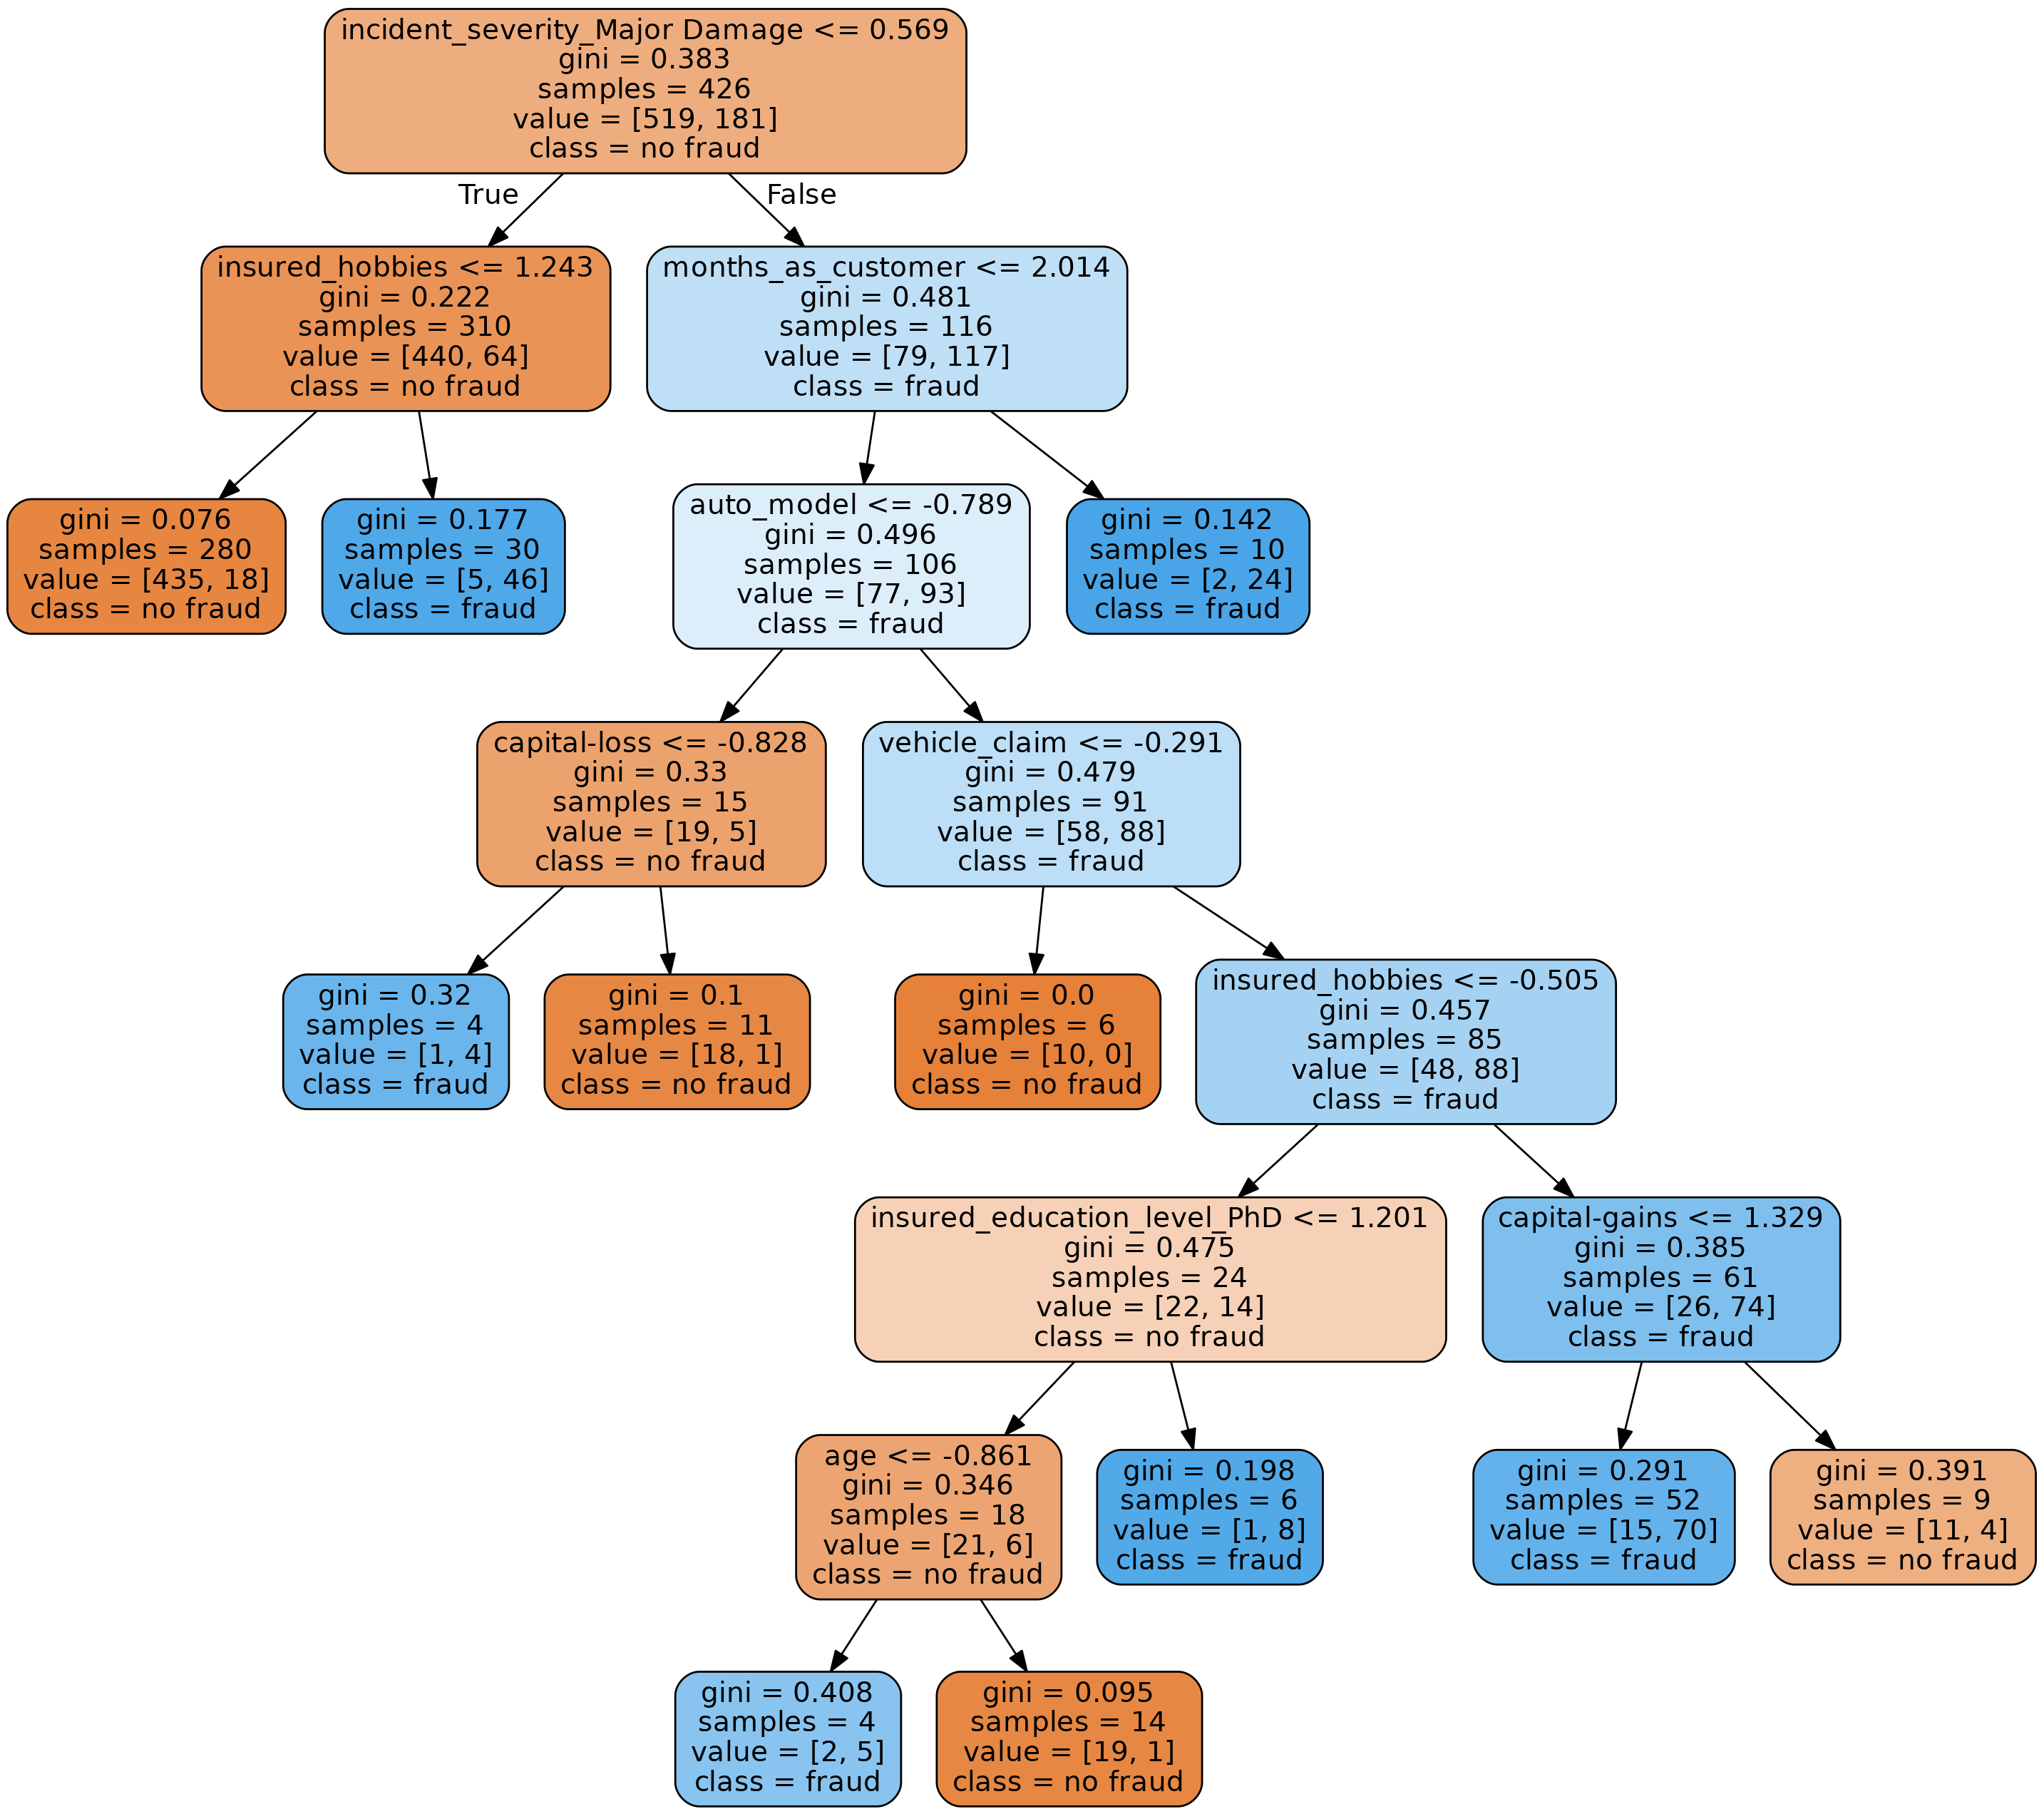

In [29]:
estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=feature_names, max_depth = 10, 
                class_names = ['no fraud', 'fraud'], filled = True)

call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')

## Diskussion

Sowohl RFC als auch CBC haben (u.a.) als wichtige Faktoren bei der Bewertung folgende Attribute identifiziert:
- incident_severity
- insured_hobbies

Zur Illustration wird der linke Pfad der RFC (siehe Abb. oben) betrachtet. Nach der incident_severity (nicht Major Damage) scheint das Hobby des Versicherten eine wichtige Rolle zu spielen: Aus den Trainingsdaten werden die Hobbies identifiziert, welche Relevanz haben:

In [30]:
X_train_df = pd.DataFrame(data=X_train, columns=feature_names)

# select rows where incident_severity_Major Damage<=0.514 and insured_hobbies>1.366
left_path = X_train_df[(X_train_df['incident_severity_Major Damage']<=0.514) & 
                       (X_train_df['insured_hobbies']>1.366)]

# identify those (quantified) hobbies, which are at least suspicious
print('min value for suspicious hobbies: ' + str(X_train0.iloc[left_path.index,:]['insured_hobbies'].min()))

# list of hobbies with associated values: 
data[data.fraud_reported==1]['insured_hobbies'].value_counts(normalize=True)

min value for suspicious hobbies: 0.10526315789473684


chess             0.153846
cross-fit         0.105263
reading           0.068826
yachting          0.064777
board-games       0.056680
paintball         0.052632
base-jumping      0.052632
polo              0.052632
hiking            0.048583
skydiving         0.044534
exercise          0.044534
video-games       0.040486
bungie-jumping    0.036437
movies            0.036437
sleeping          0.032389
golf              0.024291
basketball        0.024291
camping           0.020243
kayaking          0.020243
dancing           0.020243
Name: insured_hobbies, dtype: float64

Anscheinend haben Schachspieler und Cross-Fit-Anhänger einen Hang zum Versicherungsbetrug. Diese These wird an allen Daten überprüft: Es werden jene Fälle ausgewählt, bei denen es sich nicht um einen "Major Damage" handelt und bei welchen die Versicherten einem der beiden Hobbies nachgehen. 

Die folgende Abbildung zeigt sehr deutlich, dass in dieser Gruppe der Anteil von Betrugsfällen extrem hoch ist. 

In [31]:
test_left_path = raw_data[(~raw_data.incident_severity.isin(['Major Damage'])) & 
                          (raw_data.insured_hobbies.isin(['chess', 'cross-fit']))].fraud_reported.value_counts(normalize=True)

fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Bar(name='no major damage and playing chess or cross-fit', x=test_left_path.index, y=test_left_path), row=1, col=2)
fig.update_layout(yaxis=dict(tickformat="%"), height=400, title='fraud?', showlegend=True)

fig.show()